In [1]:

import pandas as pd
import numpy as np
import random
from scipy.stats import loguniform, lognorm
from scipy import stats
import time
import math
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import anndata as ad
import scanpy as sc

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [5]:
%ls fibroblast_SS3/processed_data/

Parameter format not correct - "processed_data".


In [6]:
adata = ad.read("data/mus_musculus_preprocessed_all_params.h5ad")
adata

AnnData object with n_obs × n_vars = 682 × 7439
    obs: 'plate', 'leiden', 'clusters', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'sum_allele_c57', 'sum_allele_cast', 'sum_ratio_allele_c57', 'sum_ratio_allele_cast', 'ratio_sum_allele_c57', 'ratio_sum_allele_cast', 'ratio_mean_allele_c57', 'ratio_mean_allele_cast', 'ratio_std_allele_c57', 'ratio_std_allele_cast', 'allele_p_value', 'gene_name', 'chromosome', 'autosomes', 'nuclear', 'Ribosomal_prot', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'c57_kon', 'c57_koff', 'c57_ksyn', 'cast_kon', 'cast_koff', 'cast_ksyn', 'total_kon', 'tota

In [7]:
adata.var

,Accession,Chromosome,End,Start,Strand,sum_allele_c57,sum_allele_cast,sum_ratio_allele_c57,sum_ratio_allele_cast,ratio_sum_allele_c57,...,spliced_ksyn,unspliced_kon,unspliced_koff,unspliced_ksyn,total_s_u_kon,total_s_u_koff,total_s_u_ksyn,unspliced_by_total_kon,unspliced_by_total_koff,unspliced_by_total_ksyn
Gene,,,,,,,,,,,,,,,,,,,,,
Mrpl15,ENSMUSG00000033845,1,4785739,4773206,-,1175.0,1092.0,0.518306,0.481694,153.475673,...,2190.929841,0.075268,1.504743,139.701396,2.176995,12.495542,2190.929841,0.001,1.362095,1.000000
4732440D04Rik,ENSMUSG00000090031,1,6214590,6213293,-,1498.0,1261.0,0.542950,0.457050,308.882750,...,80.359250,0.001000,156.828722,1.000000,0.049667,4.569173,80.359250,0.001,156.828722,1.000000
Cops5,ENSMUSG00000025917,1,10038127,10024602,-,8192.0,7966.0,0.506993,0.493007,323.482196,...,11898.416600,0.114069,2.747117,277.678309,3.656598,29.409660,11898.416600,0.001,1.361855,32.486808
Arfgef1,ENSMUSG00000067851,1,10232670,10137571,-,1841.0,1842.0,0.499864,0.500136,284.025982,...,22803.915975,0.635087,7.516546,1120.810458,1.756567,184.983916,22803.915975,NaN,NaN,NaN
Tram1,ENSMUSG00000025935,1,13589864,13564702,-,7514.0,7028.0,0.516710,0.483290,350.605317,...,1.000000,0.282150,5.544402,826.352109,0.001000,8.264970,1.000000,0.001,1.362074,1.092651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Exosc7,ENSMUSG00000025785,9,123136129,123113215,+,3556.0,3447.0,0.507782,0.492218,317.695221,...,1772.273585,0.096363,1.875123,239.556712,1.229338,6.279444,1772.273585,NaN,NaN,NaN
Lars2,ENSMUSG00000035202,9,123462664,123366940,+,376.0,763.0,0.330114,0.669886,114.946627,...,1391.569082,0.211345,6.729131,513.758124,0.912919,18.076687,1391.569082,NaN,NaN,NaN
Sacm1l,ENSMUSG00000025240,9,123592598,123529882,+,1444.0,1262.0,0.533629,0.466371,267.715853,...,NaN,0.443060,15.381805,1889.522526,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
gene_name="Fh1"
gene_index = adata.var_names.tolist().index(gene_name)
gene_value = adata.X[:,gene_index].toarray()

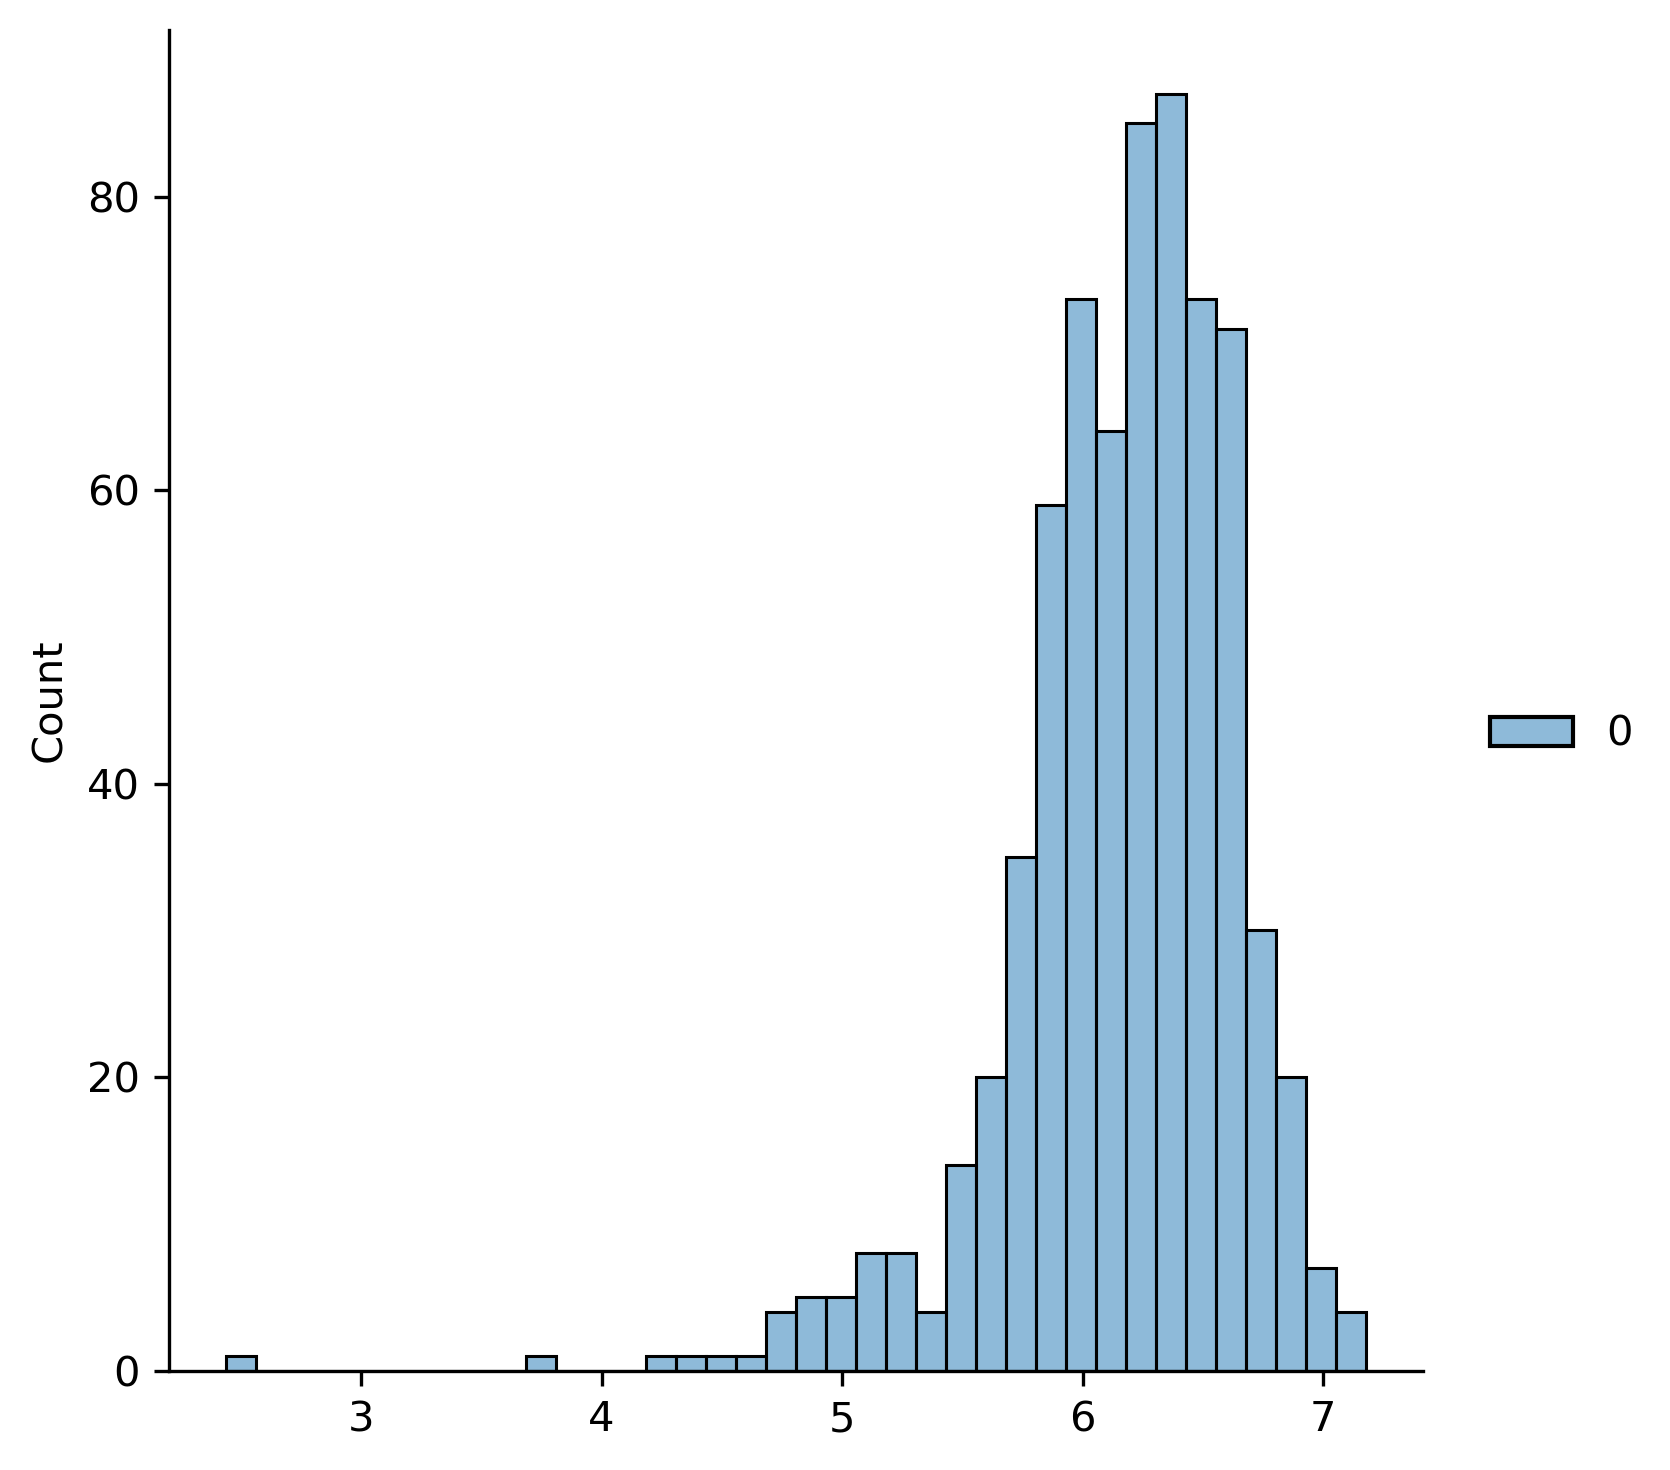

In [9]:
sns.displot(gene_value, kind='hist')

<AxesSubplot:ylabel='Density'>

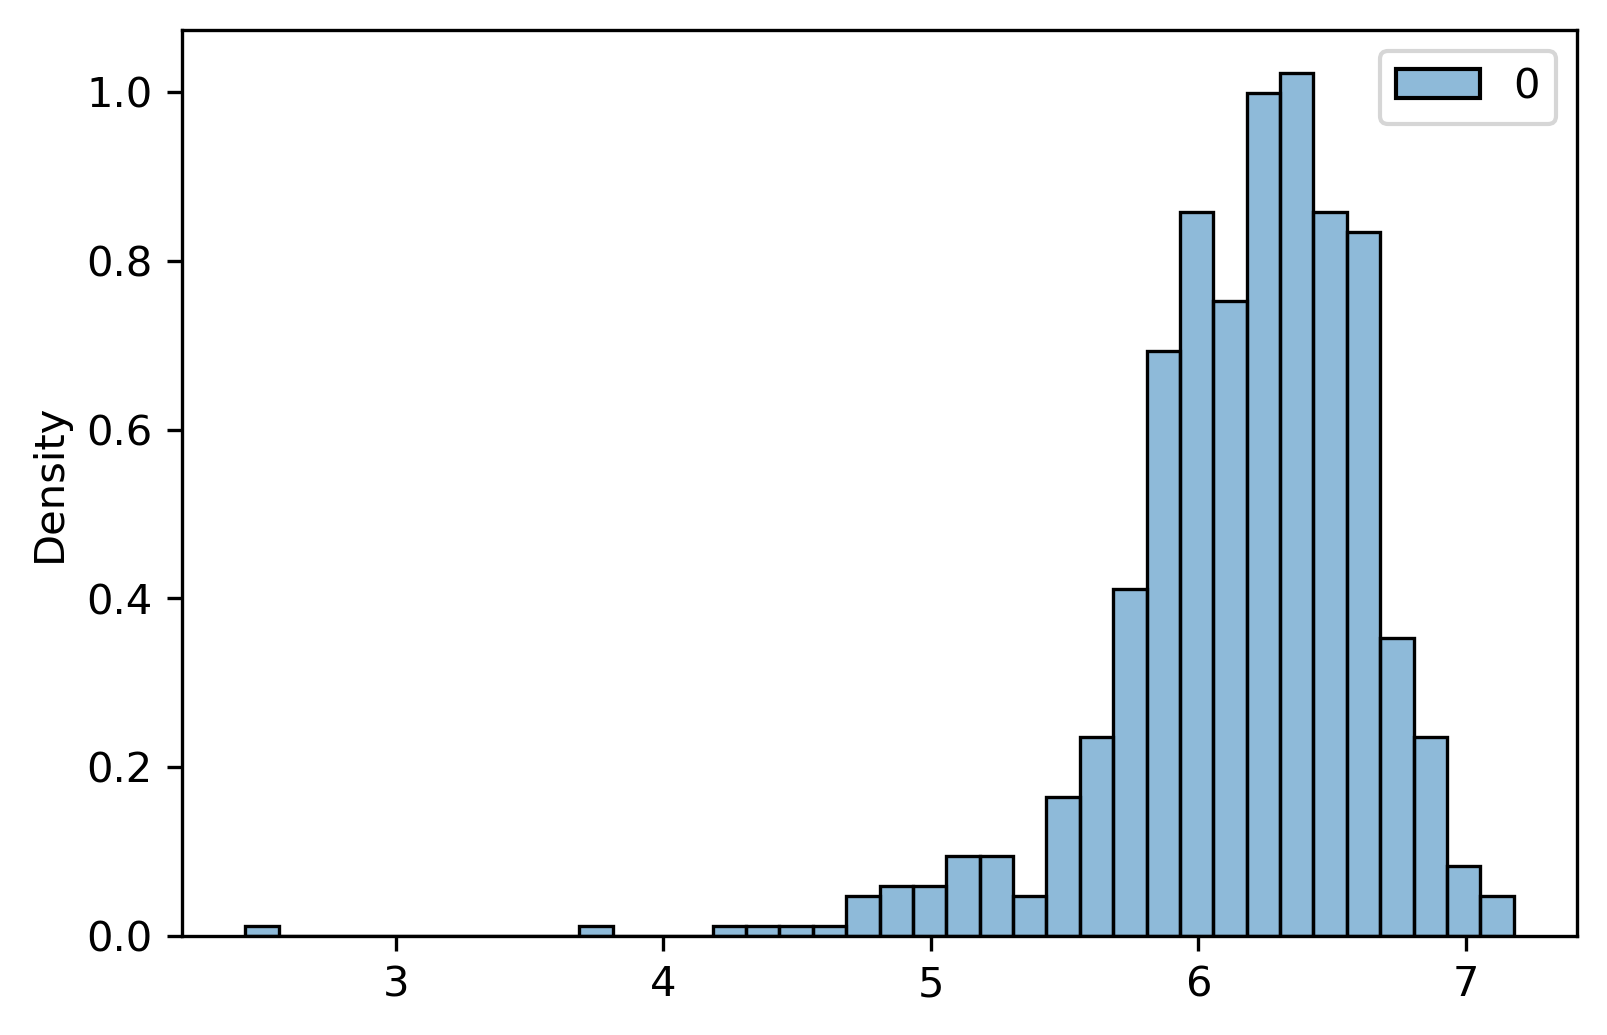

In [10]:


sns.histplot(gene_value, kde=False, stat="density")



# df with parameters

In [11]:
import pandas as pd
import numpy as np

def npy2df(input_file, return_gene_info=False):
    """
    Load the npy file with X number of bursting parameter estimation for a given gene. 
    if return_gene_info is True : 
        return the df containing the estimation, the gene index number (starting from 1, not 0) and a gene array of some sort?
    else: return the dataframe with the parameter estimation as column and each estimation attemps as rows
        
    """
    gene_no, gene, result = np.load(input_file, allow_pickle='True')
    
    result_flatten = result.flatten()
    df = pd.DataFrame([x for x in result_flatten])
    
    if return_gene_info:
        return(df, gene_no, gene)
    else:
        return(df)
    
def BFandBS(df):
    """
    input is the dataframe containing the parameters as columns.
    need column named 'koff', 'roff', 'kon', 'ron' 
    
    compute burst frequency and burst size from the parameters
    """
    df['tau_off']= df['kon']/df['ron']
    df['tau_on'] = df['koff']/df['roff']
    df['bf'] = 1./(df['tau_on'] + df['tau_off'])
    df['bs'] = df['mu'] * df['tau_on']
    


In [12]:
df = npy2df('data/posterior/gene_Fh1.npy')
BFandBS(df)
df

,kon,ron,koff,roff,mu,delta,dist,tau_off,tau_on,bf,bs
0,4.532311,9.236297,1.402771,1.643830,98.380989,1.0,0.274666,0.490706,0.853356,0.744013,83.953963
1,2.412495,6.052100,2.534706,6.625224,113.777361,1.0,0.327767,0.398621,0.382584,1.280073,43.529423
2,6.366312,14.505751,2.645333,5.125228,151.539727,1.0,0.309247,0.438882,0.516140,1.047097,78.215642
3,10.992992,18.563614,1.402629,1.115317,83.907614,1.0,0.352684,0.592180,1.257606,0.540603,105.522735
4,6.317921,10.510005,8.825892,15.085610,138.388045,1.0,0.271651,0.601134,0.585054,0.843037,80.964439
...,...,...,...,...,...,...,...,...,...,...,...
4995,1.274044,2.858253,2.420984,3.944639,77.123102,1.0,0.645964,0.445742,0.613740,0.943857,47.333553
4996,5.411791,11.966271,3.562691,5.847303,99.513757,1.0,0.535663,0.452254,0.609288,0.942026,60.632523
4997,3.521019,7.949049,5.816684,16.650460,172.366368,1.0,0.271080,0.442948,0.349341,1.262166,60.214593
4998,1.990243,6.853242,3.269729,19.697935,198.778096,1.0,0.236898,0.290409,0.165993,2.191049,32.995866


<AxesSubplot:xlabel='kon', ylabel='Density'>

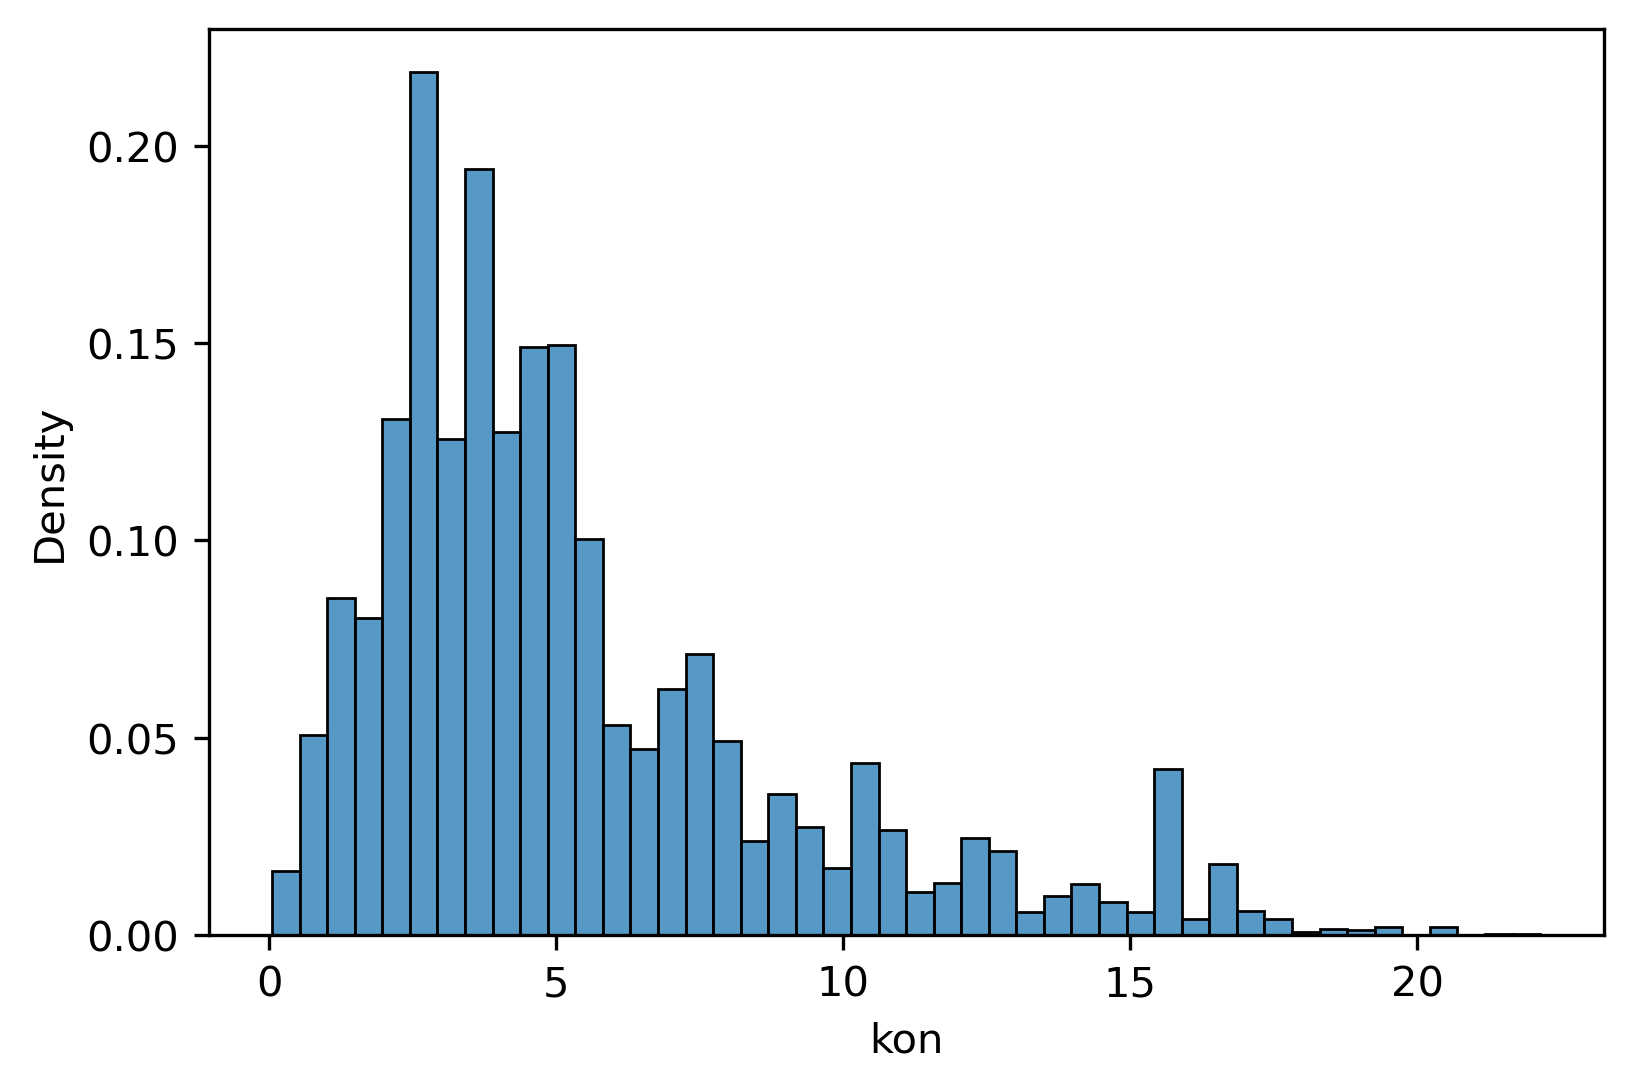

In [13]:
sns.histplot(df['kon'], kde=False, stat="density")

<AxesSubplot:xlabel='mu', ylabel='Density'>

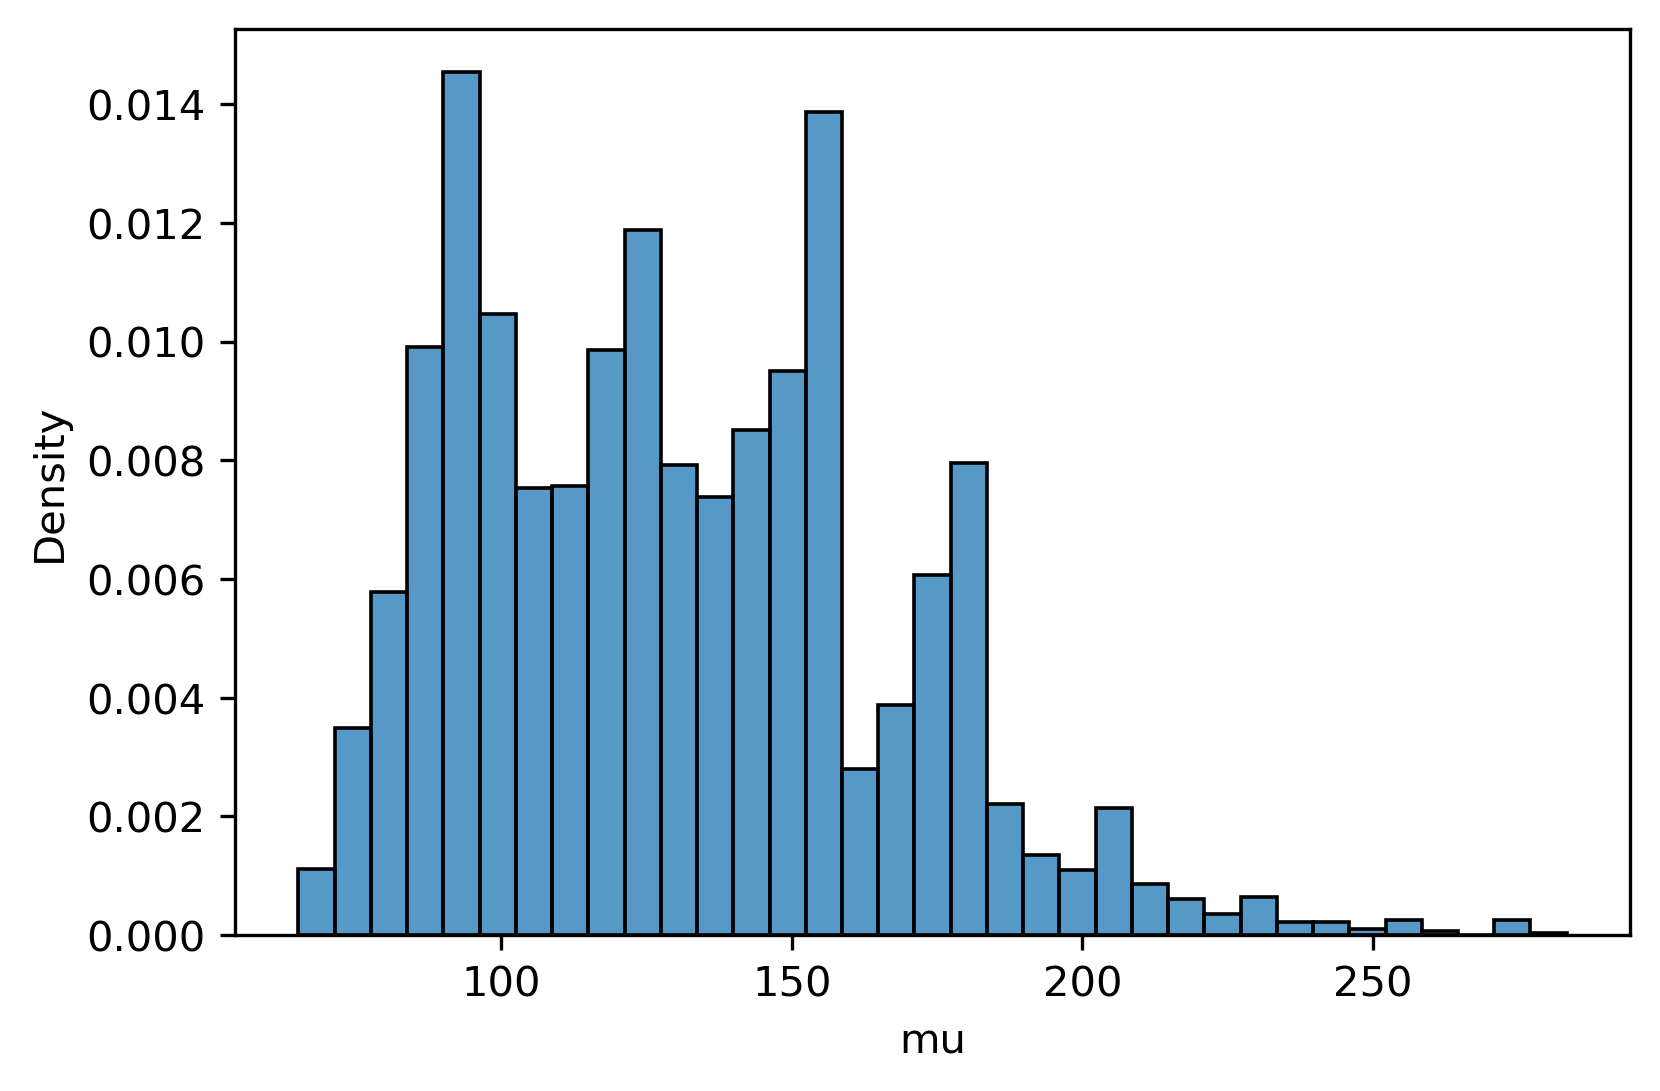

In [14]:
sns.histplot(df['mu'], kde=False, stat="density")